# Encompassing Backtester

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from IPython.display import clear_output

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [2]:
df1 = pd.read_csv("../data/minute/CELRUSDT-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/minute/FETUSDT-minute.csv", index_col=0, parse_dates=True)

In [3]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
df = df[1000:]
df = df.dropna()

## Hedge Ratio calculation

In [4]:
ds = 1000 #downsample
hedge_ratio = np.full(df.shape[0], np.nan)
l = math.floor(len(hedge_ratio)/ds)
index = []
for t in np.arange(l):
    clear_output()
    print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df[:t*ds+1]).fit()  # Note this can deal with NaN in top row
    hedge_ratio[t] = regress_results.params[1]
    index.append(df.index[t*ds+1])

1210 < 1211


In [5]:
hr = pd.Series(hedge_ratio).dropna().rename("hr").to_frame()

hr["index"] = index
hr.set_index("index", inplace=True)

spread = pd.DataFrame(hr.hr, index=df.index)

spread.ffill(inplace=True)

spread = pd.Series((df['B'] - spread["hr"] * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(4250).mean()
spread["std"] =  spread.spread.rolling(4250).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

spread = spread.dropna()

spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)

spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)

# spread.index = (range(len(spread))) #If using XXXUSDT-past.csv

In [6]:
print(len(spread))
spread = spread[-700_000:]

1207387


## Backtester

In [7]:
def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

def run_backtest(spread, thres, sell_thres, fee=0.002, interest=0.002):
    total, p_total = 0, 0 #Previous total
    cusum, returns = [], []
    price_a, price_b, long = None, None, None #Values: None, "A", "B"
    long_a, long_b, liquidate,  dd_indices= [], [], [], [] #Drawdown indicies
    dd_i = True
    for i in range(spread.shape[0]):
        z = spread.zscore[i]
        if long == None: # Looking to buy
            if z>thres or z<-thres:
                al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
                price_a = ah if z > thres else al
                price_b = bl if z > thres else bh
                long = "A" if z > thres else "B"
                long_a.append(spread.index[i]) if z > thres else long_b.append(spread.index[i])
        if (long == "A" and z<-sell_thres) or (long == "B" and z>sell_thres): #Liquidate positions
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            gain = 0
            if long=="A":
                gain = liquidate_assets(price_b, bh, al, price_a, fee, long_a[-1], spread.index[i], interest)
            else:
                gain = liquidate_assets(price_a, ah, bl, price_b, fee, long_b[-1], spread.index[i], interest)
            returns.append(gain)
            total += gain
            price_a, price_b, long = None, None, None
            liquidate.append(spread.index[i])
        cusum.append(total)

        if total < p_total:
            if dd_i:
                dd_indices.append(spread.index[i])
                dd_i = False
        else:
            if not dd_i:
                dd_indices.append(spread.index[i])
                dd_i = True
            p_total = total
    if total < p_total:
        dd_indices.append(spread.index[i])
    drawdowns = get_drawdowns(dd_indices)
    return long_a, long_b, liquidate, cusum, returns, drawdowns
        
def liquidate_assets(x1, x2, y1, y2, fee, d1, d2, interest):
    interest = ((d2-d1).days + 1) * interest
    total = (x1 - x2)/x1 - 2*fee - interest
    total += (y1 - y2)/y1 - 2*fee - interest
    return total

def get_drawdowns(dd_indices):
    a = dd_indices[1::2]
    b = dd_indices[::2]
    a = np.array(a)
    b = np.array(b[:len(a)])
    c = a-b
    c.sort()
    return c[::-1]

In [8]:
long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, 3.4, 0.25)

<AxesSubplot:>

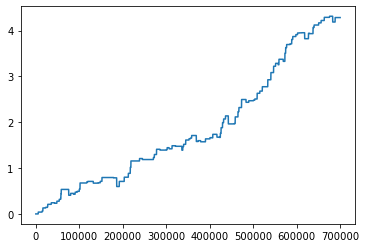

In [9]:
pd.Series(cusum).plot()

<AxesSubplot:>

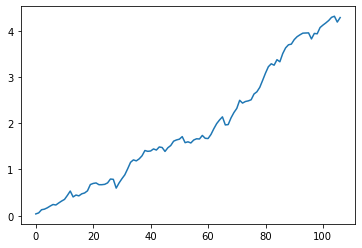

In [10]:
pd.Series(returns).cumsum().plot()

In [12]:
len(list(filter(lambda x: x>0, returns)))

252

In [45]:
def convert_timedelta_to_seconds(td):
    """converts timedelta to seconds"""
    return td.days*24*60*60 + td.seconds

In [20]:
drawdowns

array([Timedelta('26 days 11:40:00'), Timedelta('17 days 12:14:00'),
       Timedelta('17 days 02:34:00'), Timedelta('16 days 21:51:00'),
       Timedelta('15 days 10:13:00'), Timedelta('14 days 00:33:00'),
       Timedelta('13 days 08:57:00'), Timedelta('12 days 22:30:00'),
       Timedelta('12 days 00:44:00'), Timedelta('11 days 11:11:00'),
       Timedelta('11 days 01:56:00'), Timedelta('5 days 10:23:00'),
       Timedelta('4 days 16:07:00'), Timedelta('3 days 16:21:00'),
       Timedelta('2 days 15:56:00'), Timedelta('1 days 06:40:00')],
      dtype=object)

In [48]:
d = {"A":[[1, 2, 3], [2, 3, 4]], "B":[3, 4]}

In [65]:
d = pd.Series(cusum).diff()

In [ ]:
acc = []
for i in range(len(d)/1440)

In [68]:
d.to_csv("returnss.csv", index=False)

In [51]:
d = pd.read_csv("returnss.csv")
d

,A,B
0,"[1, 2, 3]",3
1,"[2, 3, 4]",4


In [52]:
d["A"] = d["A"].apply(eval)

In [55]:
d.A[0]

[1, 2, 3]

In [17]:
import ast

In [20]:
# ast.literal_eval(d.A[0])

In [22]:
# d["A"] = list(map(lambda x: list(ast.literal_eval(x)), d.A))
# d